In [ ]:
%load_ext autoreload
%autoreload 2

### Tutorial covering using Miniai for Image Classification

This tutorial covers how to use the miniai library for image classification.  It begins with Mnist and then moves to the Imagenet Tiny.  The evolution of the models includes the use of data augmentation techniques.  Starting with Fashion Mnist

### Import Libraies and setup

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

In [ ]:
from miniai.datasets import DataLoaders, get_dls, collate_dict, inplace
from miniai.callbacks import (MetricsCB, DeviceCB, ProgressCB, TrainCB, 
                              BatchSchedCB, RecorderCB, OneCycleLrCB)
from miniai.learner import Learner, TrainLearner, LRFinderCB
from miniai.plotting import show_image, show_images
from miniai.model_blocks import conv, ResBlock, lin, pre_conv
from miniai.utils import set_seed, def_device
from miniai.activations import append_stats, ActivationStatsCB
from miniai.layers import GeneralRelu
from miniai.init import init_weights

### Set basic parameters and defaults

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

### Load and configure Mnist Data 

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

### Prepare Model callbacks, initialization, progress monitoring and metrics

Load the callback to capture activations during training.  In this case the module filter is set to GeneralRelu, which means that activations will be captured for every instance of that in the model. As an alternative the "mods" parameter can be used to define a list of layers for which activations will be captured.  This might be more appropriate for larger models to prevent activations from too many layers being captured.

In [ ]:
astats = ActivationStatsCB(module_filter=fc.risinstance(GeneralRelu))

Create a callback fo capture metrics during training.  In this case Multiclass accuracy.  Additional metrics can be created and assigned using keyword arguments.  Any metric defined using TorchEval should work.  In addition the metrics could be supplied in a list (without the keyword argument)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())

In [ ]:
device_cb = DeviceCB()

Add a progress callback to print out and, optionally, plot training results

In [ ]:
progress_cb = ProgressCB(plot=True)

Add callbacks to define the following methods in the Learner:
1. predict
2. get_loss
3. backward
4. step
5. zero_grad

The above functions are what would be expected for normal straightforward training as is required for object classification.  The beauty of the way these are structured in a callback means that these functions can be easily changed if a more complex or unusual model training is required

In [ ]:
train_cb = TrainCB()

Create a list of the callbacks to be used in the model.  Others can be added if needed

In [ ]:
cbs = [device_cb, metrics, progress_cb, astats, train_cb]

Create an activation function based on the GeneralRelu with predefined values for leak and sub

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

Define an initialisation function.  This will be applied to any conv layer and will assign a Kaiming normal initialisation using the value for leaky define

In [ ]:
iw = partial(init_weights, leaky=0.1)

Create a function to generate a ResNet style model using ResBlocks.  The ResBlocks have a conv block containing two conv layers, with the first conv block changing the number of channels and the second the resolution (if required).  Activations is by default only applied to the output form the first conv block.

As well as the conv block the ResBlock also has a pass through path that uses a pooling layer (if the resolution needs to be changed) and a conv layer (if the nuber of channels needs to change). After the outputs from the pass through path and the conv block are combined an optional activation can be applied

In the function below blocks are stacked with progressively increasing numbers of channels (if the defaults are used).  By default BatchNorm2d is used for normalisation, 

In [ ]:
def get_model(act=nn.ReLU, nfs=(8, 16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, nfs[0], stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act, norm=norm) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)

Create a learner using the callbacks and model created

In [ ]:
learn = Learner(model=model, dls=dls, loss_func=F.cross_entropy, lr=0.001, cbs=cbs, opt_func=optim.Adam)

There is a very useful ".summary() method built into the learner that will summarise the input and output shapes of the layers as well as summarizing the number of parameters in the model.  The result of running the model is shown below where it can be seen how the number of parameters increased as the model gets deeper, but also how the downsizing means that the last conv has only a 1x1 resolution, though a large number of channels.

In [ ]:
learn.summary()

Total Parameters: 1227900


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 8, 28, 28)|696|
|ResBlock|(1024, 8, 28, 28)|(1024, 16, 14, 14)|3664|
|ResBlock|(1024, 16, 14, 14)|(1024, 32, 7, 7)|14496|
|ResBlock|(1024, 32, 7, 7)|(1024, 64, 4, 4)|57664|
|ResBlock|(1024, 64, 4, 4)|(1024, 128, 2, 2)|230016|
|ResBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|918784|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2560|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|


### Training the Model 

Everything is ready to train the model.  There is a lot more that can be done to improve the performance but to provide a baseline this model will be trained before some additional features are introduce to improve performance further.  It is helpful to explore what sort of learning rate might work for this model.  There is a method (.lr_find) in the Learner to explore this.

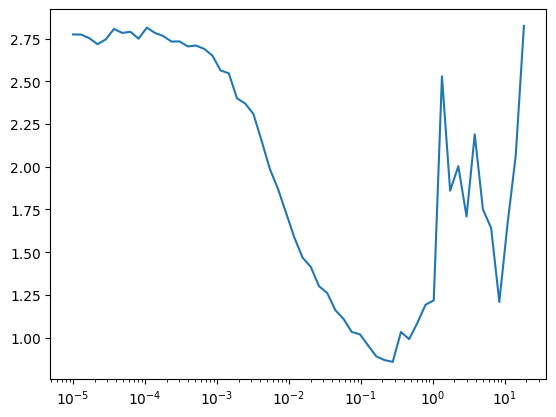

In [ ]:
learn.lr_find()

It is desirable to use a learning rate as high as possible before the minima. In this case 1E-3 is not a bad starting point.  Initially the model will be trained for 5 epochs and this will serve to compare performance when additional features are added

accuracy,loss,epoch,train
0.779,0.747,0,train
0.852,0.536,0,eval
0.887,0.361,1,train
0.878,0.385,1,eval
0.905,0.287,2,train
0.875,0.366,2,eval
0.915,0.248,3,train
0.901,0.278,3,eval
0.919,0.228,4,train
0.908,0.264,4,eval


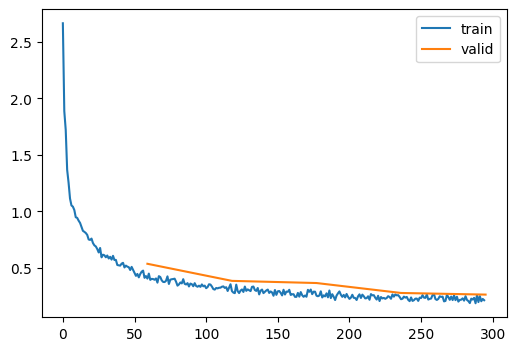

In [ ]:
learn.fit(n_epochs=5, lr=1.e-2)

The best performance on the validation set is 90.8% and is still improving.  Not bad and the model can be made larger if needed.  Before that, however, there are other improvements that can be made.  The two that will be added next are:
1. Learning Rate Schedulers
2. Data Augmentation

### Learning Rate Schedulers 

Learning rate schedulers can be constructed by inheriting from the base classes BaseSchedCB.  Two specific implementations are BatchSchedCB and EpochSchedCB.  BatchSchedCD takes a scheduler as input and applied a step after every batch.  EpochSchedB does the same but after each epoch, and hence is a much more coarse way of applying the scheduler.

In addition there is a callback OneCycleLrCB that is specifically tailored to make it easy to use the One Cycle Learning Rate Policy developed by Leslie Smith [link to paper](https://arxiv.org/pdf/1506.01186.pdf)

As a demonstation and comparison of a Cosine annealing and the OneCycle annealing both will be implemented.  In order to facilitate plotting the changes in optimiser parameters an additional callback RecorderCB has also been developed and will be used.

#### Cosine Annealing

In this case the BatchSchedCB will be used.  The necessary steps are:
1. Define the total number of steps over which to apply the schedule
2. Create a partial function with the scheduler and the max steps to apply it over
3. Create a callback with the partial scheduler function.  Note that any other of the scheduler arguments can also be assigned at this point

The following illustrated the process

In [ ]:
# Define how many epochs to use for the training step
n_epochs=5
# Calculate the number of steps
total_steps = n_epochs * len(dls.train)
# Create the partial scheduler
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=total_steps)
# Create the callback
sched_cb = BatchSchedCB(sched)

# Define a function to return the learning rate for the recorder
def _lr(cb):
    """ Return the learning rate for a specific parameter group
    """
    return cb.pg['lr']

def _beta0(cb):
    """ Return the momentum for a specific parameter group
    """
    return cb.pg['betas'][0]

def _beta1(cb):
    """ Return the momentum for a specific parameter group
    """
    return cb.pg['betas'][1] 


recorder_cb = RecorderCB(lr=_lr, beta0=_beta0, beta1=_beta1)

In [ ]:
model = torch.nn.Sequential(torch.nn.Conv2d(3, 6, kernel_size=3), torch.nn.Conv2d(6, 12, kernel_size=3))

In [ ]:
opt = torch.optim.Adam

accuracy,loss,epoch,train
0.774,0.729,0,train
0.830,0.490,0,eval
0.880,0.349,1,train
0.878,0.349,1,eval
0.906,0.267,2,train
0.887,0.322,2,eval
0.923,0.220,3,train
0.911,0.247,3,eval
0.936,0.188,4,train
0.917,0.235,4,eval


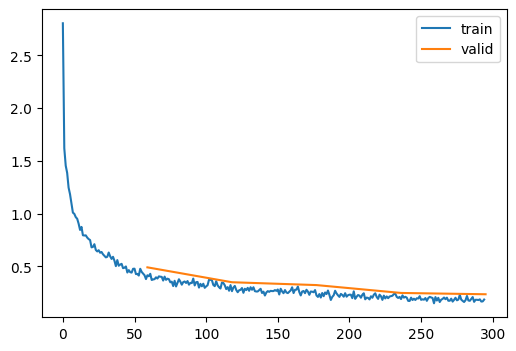

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
xtra = [sched_cb,recorder_cb]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=opt)
learn.fit(5)

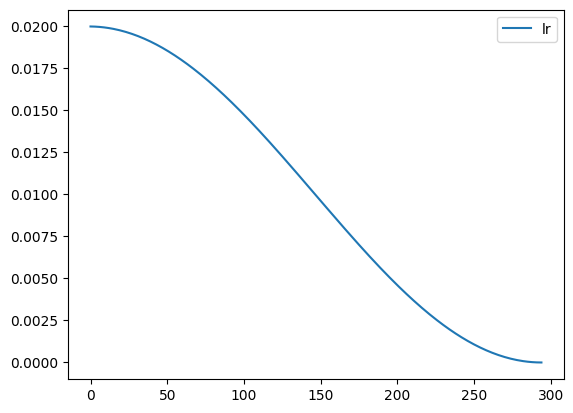

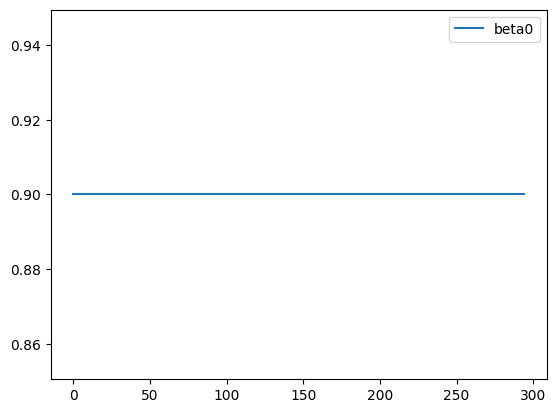

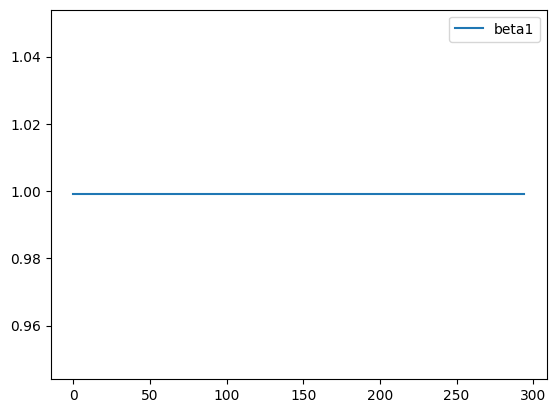

In [ ]:
recorder_cb.plot()

It can be seen that the cosine annealing does not change the momentum term of the Adam optimiser.  In this case the accuracy of the model after 5 epochs is slightly better than that of the case without the scheculing (91.7% vs. 90.8%).  Still better results are likely to be obtainable using the OneCycle Learning rate scheduler mentioned above.  To make this a bit easier to use the callback has been written to calculate the steps etc based upon the number of epochs automatically.

#### Train using OneCycle scheduler

The parameters needed for the schedulers in pytorch vary and so it is not easy to write one high level scheduler callback that avoids the need for calculating steps etc.  In the case of the one cycle learner, this is such a frequently used callback that a customised scheduler callback has been developed.  As well as calculating the schedule using the number of epochs automatically it also facilitates passing other parameters into the callback using kwargs (for example to vary the shape of the curves, the changes to momentum etc).  This will be demonstrated using the basic settings

In [ ]:
# Define how many epochs to use for the training step
n_epochs=5

# Create scheduler
sched_cd = OneCycleLrCB(max_lr = 1.E-2)

# Define the recorder parameters
# Define a function to return the learning rate for the recorder
def _lr(cb):
    """ Return the learning rate for a specific parameter group
    """
    return cb.pg['lr']

def _beta0(cb):
    """ Return the momentum for a specific parameter group
    """
    return cb.pg['betas'][0]

def _beta1(cb):
    """ Return the momentum for a specific parameter group
    """
    return cb.pg['betas'][1] 


recorder_cb = RecorderCB(lr=_lr, beta0=_beta0, beta1=_beta1)

accuracy,loss,epoch,train
0.806,0.758,0,train
0.877,0.425,0,eval
0.896,0.386,1,train
0.882,0.390,1,eval
0.919,0.271,2,train
0.911,0.282,2,eval
0.940,0.199,3,train
0.921,0.247,3,eval
0.958,0.151,4,train
0.926,0.236,4,eval


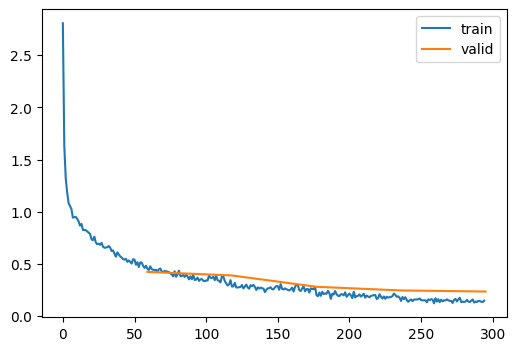

In [ ]:
set_seed(42)
opt = torch.optim.Adam
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
xtra = [sched_cd,recorder_cb]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=opt)
learn.fit(5)

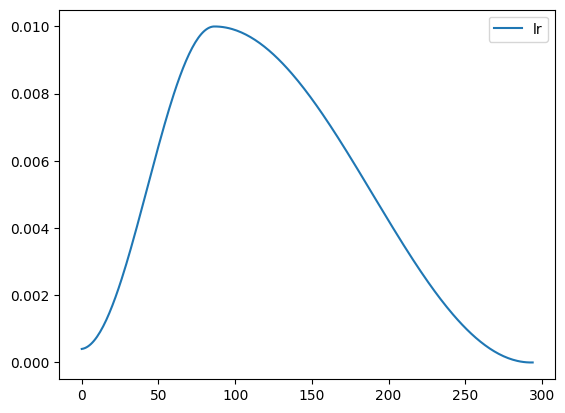

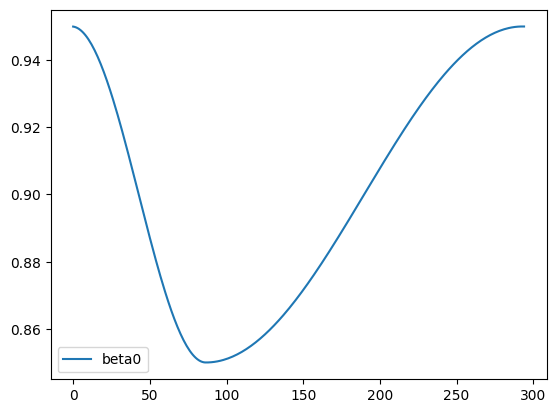

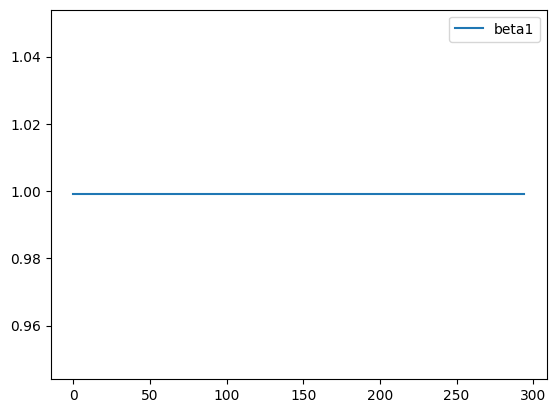

In [ ]:
recorder_cb.plot()

The use of the one cycle schedul has increased the accuracy again, this time from 91.7 to 92.6.  This might not seem much but this reduces errors by about 10% and is significant.  The plot above show how learning rate and momentum are varied by the scheduler.  In this case the momentum values are changes significantly